## Load data

Load the data and also resize and flip the widefield so the pixel size and coordinate system matches the restored

In [2]:
import mrc as Mrc
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os 
parent_path = r'D:\Janelia\Data 2024-06-12'
figure_path = r'D:\Janelia\Analysis 2024-06-12\figures'

if not os.path.exists(figure_path):
    os.makedirs(figure_path)

gApo = 0.3
supR = 10
w = 0.001
tile = False

if tile:
    output=Mrc.Mrc(os.path.join(parent_path, 'data/561nm WF correlation image 2_20240521_162301/560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1_proc_560 201909_19-20_best_gApo_'+str(gApo)+ \
                            '_supR_'+str(supR)+'_w_'+str(w)+'_tile64_pad32.mrc'))
else:
    str0 = '560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1_proc_560 201909_19-20_best_gApo_'+str(gApo)+ '_supR_'+str(supR)+'_w_'+str(w)+'.mrc'
    str1 = '560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1_proc560 201909_19-20_best_gApo_0.3_supR_10_w_0.001.mrc'
    print(str0)
    print(str1)
    output=Mrc.Mrc(os.path.join(parent_path, 'data/561nm WF correlation image 2_20240521_162301/560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1_proc560 201909_19-20_best_gApo_'+str(gApo)+ \
                            '_supR_'+str(supR)+'_w_'+str(w)+'.mrc'))
    #output=Mrc.Mrc(os.path.join(parent_path, 'data/561nm WF correlation image 2_20240521_162301/560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1_proc560 201909_19-20_best_gApo_0.3_supR_10_w_0.001.mrc'))
restored = output.data
widefield = imread(os.path.join(parent_path, '561nm Widefield no SIM illumination image 8.75 microns stack.tif'))

# get pixel spacings of restored
sxy, sxy, sz = output.header.d[0], output.header.d[1], output.header.d[2]

# I assume widefield has twice the xy pixel size as restored but same z pixel size (not sure if this is correct)
# so resize widefield so pixel size matches output
# default pixel interpolation of sksize is bilinear
widefield = resize(widefield, output.shape, anti_aliasing=True, preserve_range=True)
# flip vertically
# widefield = widefield[:,::-1,:]

#restored = np.clip(restored, 0, restored.max()/10)
restored = restored[::-1,:,:]
restored = restored[:,::-1,:]

560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1_proc_560 201909_19-20_best_gApo_0.3_supR_10_w_0.001.mrc
560 nm 655 40 filter 5 phases 0.81 NA React_All Linear SIM_cam1_1_proc560 201909_19-20_best_gApo_0.3_supR_10_w_0.001.mrc


In [3]:
restored.min(), restored.max(), widefield.min(), widefield.max()

# replace nan with 0
restored = restored.copy()
restored[np.isnan(restored)] = 0

## Show max projection of entire image

Show a max projection of the entire image so we can confirm both restored and widefield contain the same objects (they will likely be shifted)

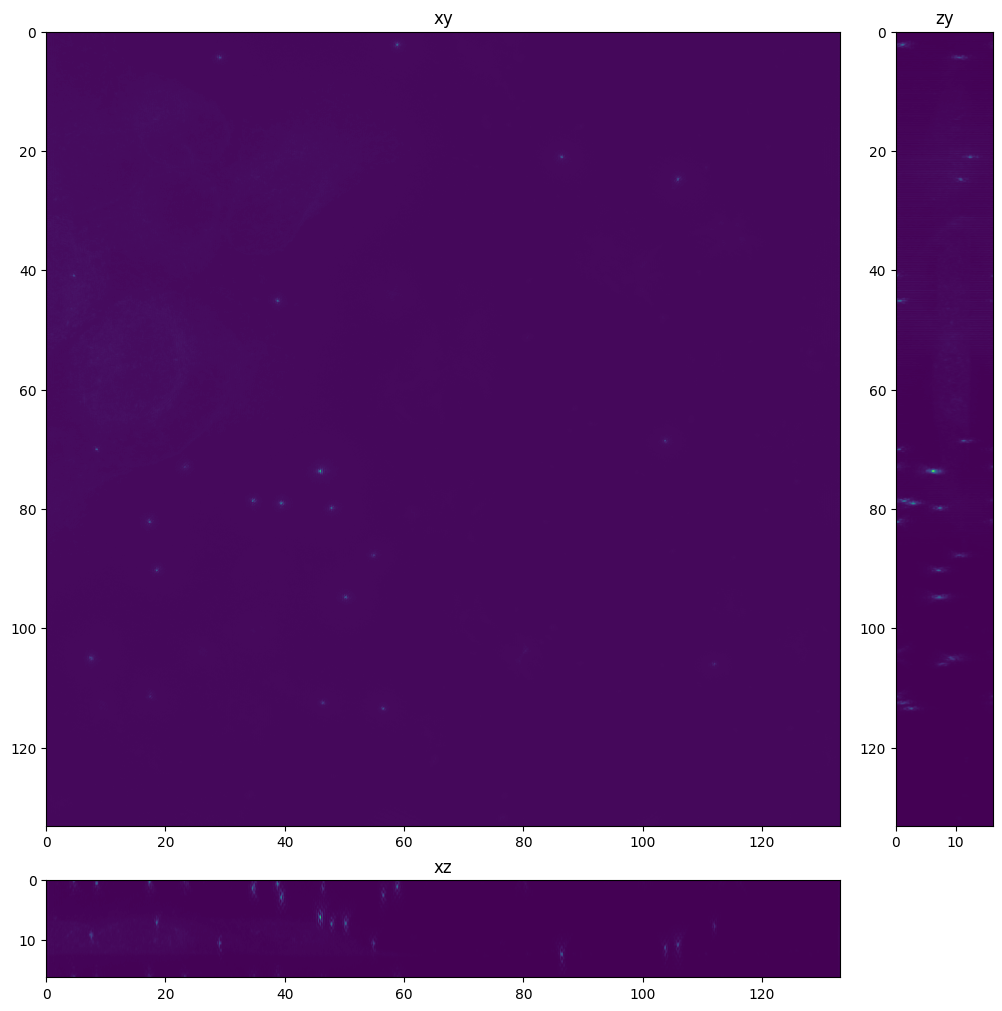

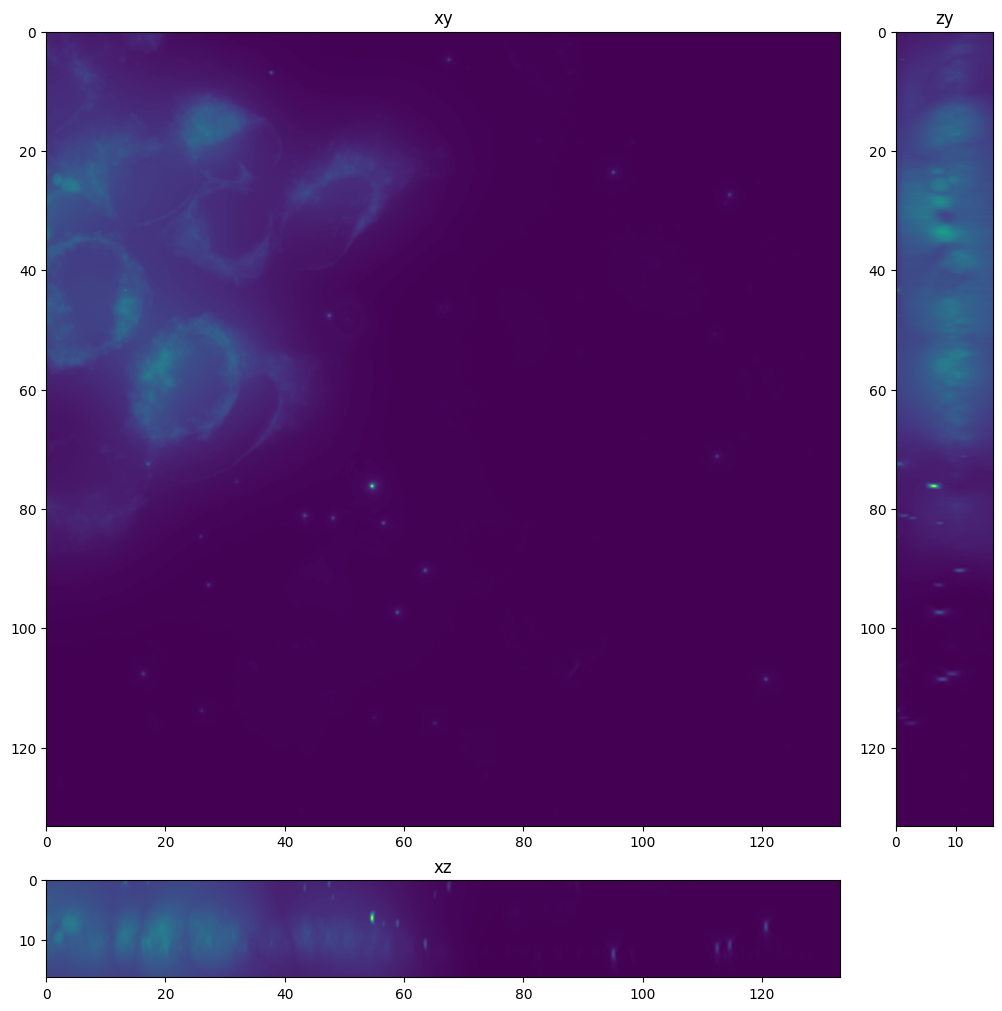

In [4]:
from tnia.plotting.projections import show_xyz_max

fig = show_xyz_max(restored, sxy=sxy, sz=sz, vmax = restored.max())
fig = show_xyz_max(widefield, sxy=sxy, sz=sz, vmax = widefield.max())


In [5]:
get_beads_from_user = False
if get_beads_from_user:

    import napari
    viewer = napari.Viewer()
    viewer.add_image(restored, name='restored')#, scale=(sz, sxy, sxy))
    viewer.add_image(widefield, name='widefield')#, scale=(sz, sxy, sxy))
    points = viewer.add_points(ndim=3, size=1, face_color='red', name='points restored')
    points = viewer.add_points(ndim=3, size=1, face_color='blue', name='points widefield')

In [6]:
if get_beads_from_user:

    points_restored=viewer.layers['points restored'].data
    points_restored = points_restored.astype('uint16')
    print(points_restored)
    np.save('./points_restored.npy', points_restored)
else:
    points_restored = np.load('points_restored.npy')

print(points_restored)

[[  49 1123  357]
 [  24 1388  284]
 [  25 1133  706]
 [   0 1263  266]]


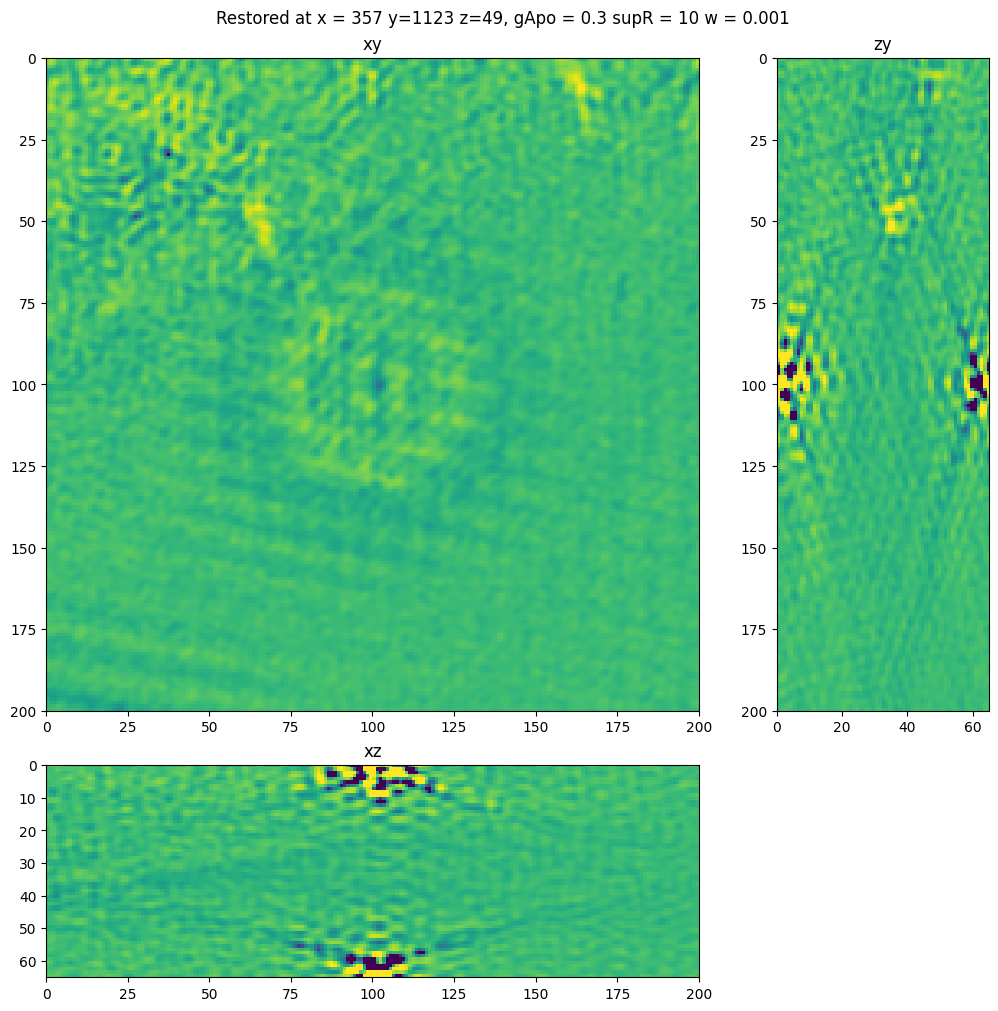

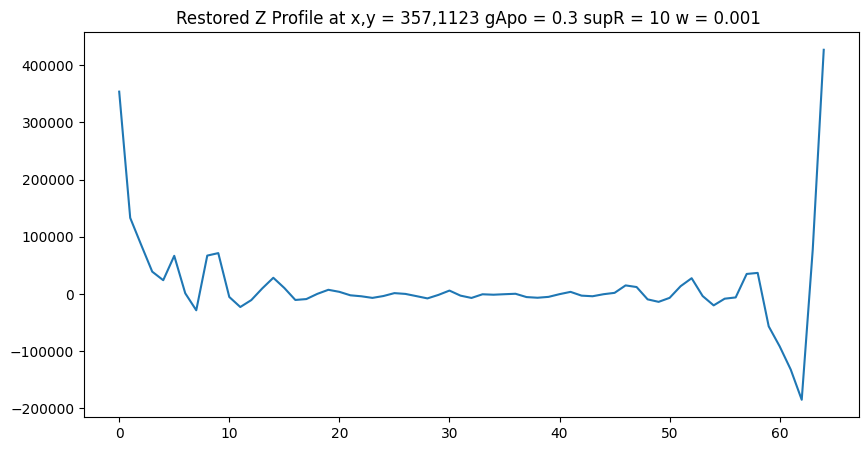

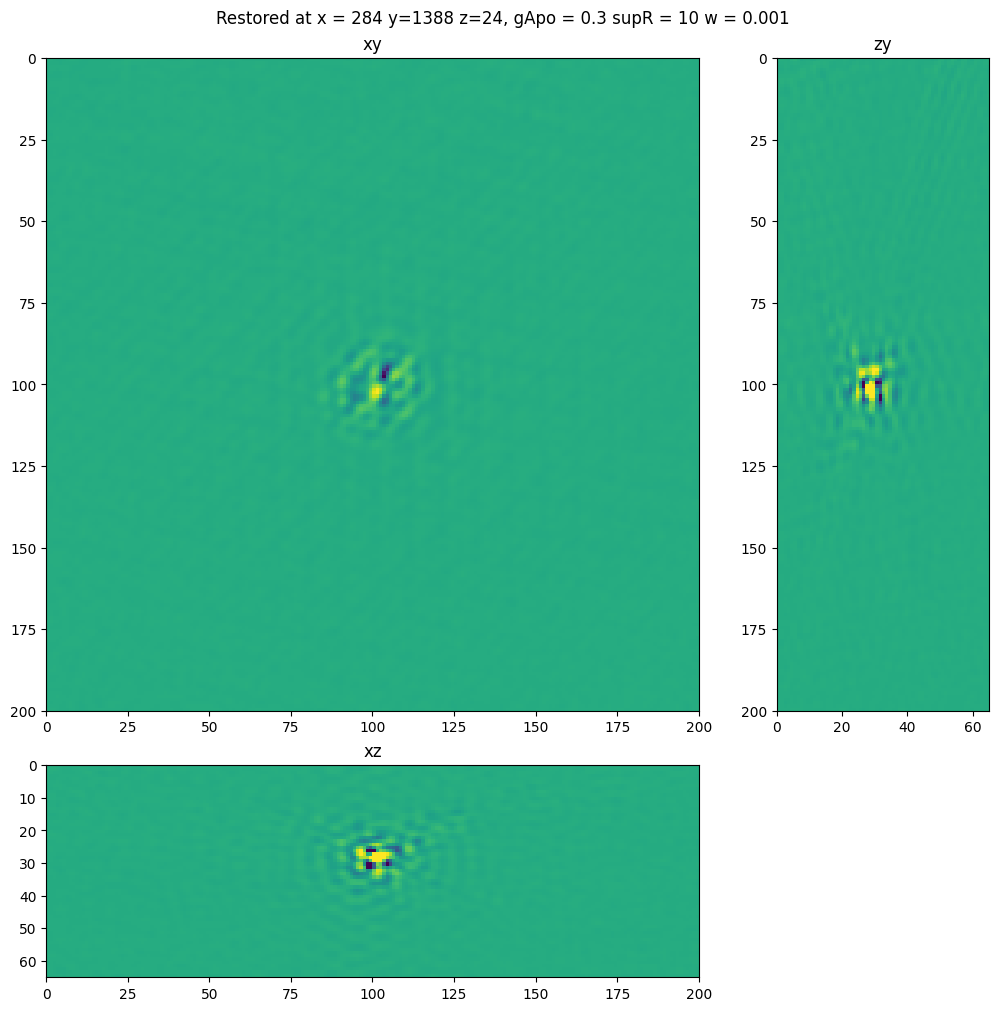

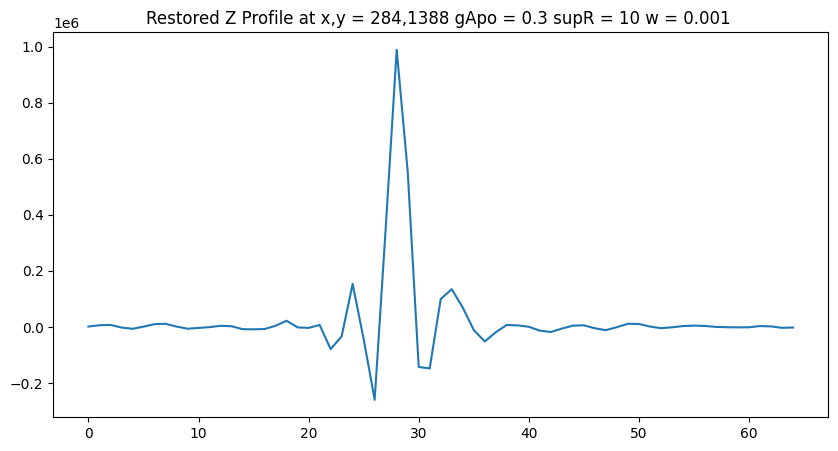

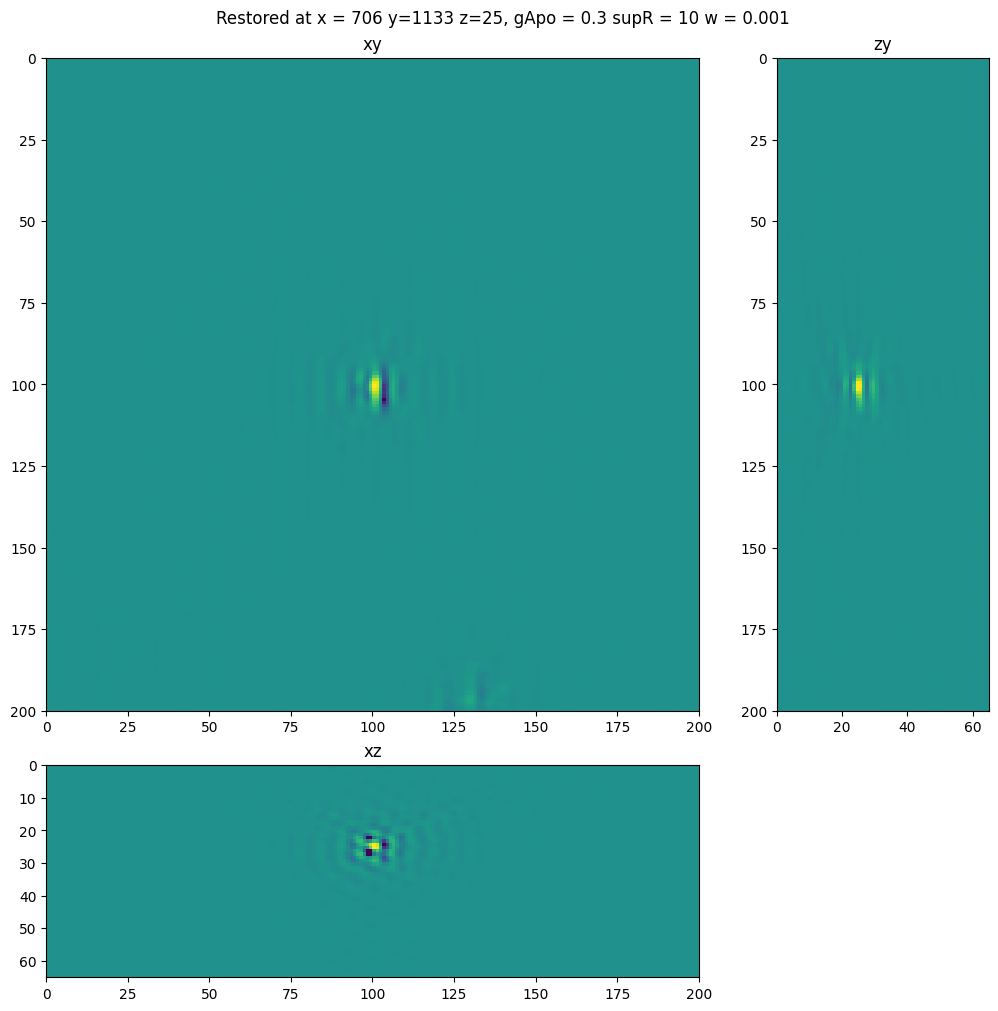

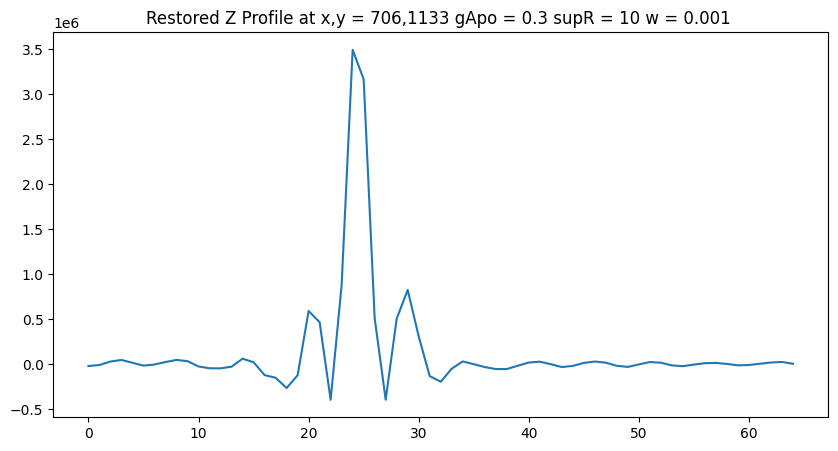

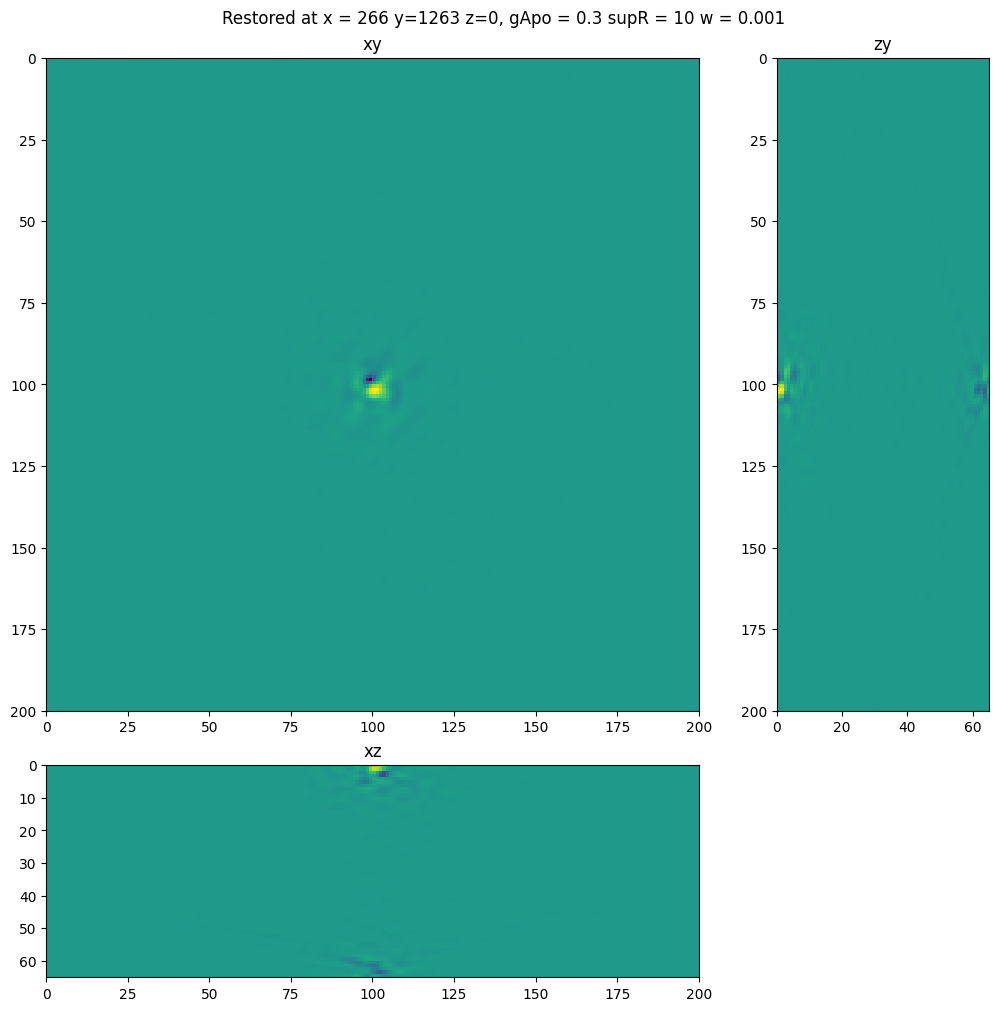

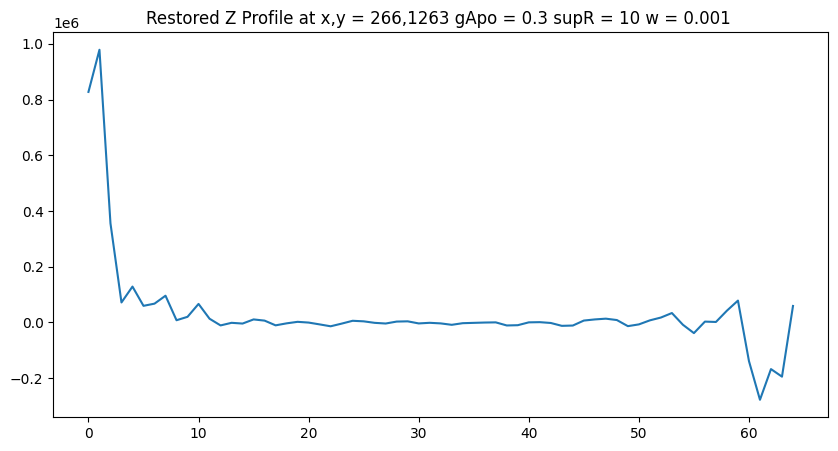

In [7]:
from tnia.plotting.interactive_projections import show_xyz_slice_interactive, show_xyz_slice
import matplotlib.pyplot as plt

def get_center_crop(data, yc, xc, w, h):
    index = np.s_[:,yc-h:yc+h,xc-w:xc+w]
    return data[index]

params_string = 'gApo = {} supR = {} w = {}'.format(gApo, supR, w)
params_path = os.path.join(figure_path, params_string)

if not os.path.exists(params_path):
    os.makedirs(params_path)

for point in points_restored:
    zcr, ycr, xcr = point
    wr, hr = 100, 100
    
    restored_crop = get_center_crop(restored, ycr,xcr,hr, wr)
    #restored_crop = restored_crop - restored_crop.min()+1
    fig = show_xyz_slice(restored_crop, wr, hr, zcr, gamma=0.5)
    fig.suptitle('Restored at x = {} y={} z={}, gApo = {} supR = {} w = {}'.format(xcr, ycr, zcr, gApo, supR, w))
    fig.savefig(os.path.join(params_path, 'restored_{}_{}_{}.png'.format(xcr, ycr, zcr)))

    z_profile_restored = restored_crop[:,hr,wr]

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    ax.plot(z_profile_restored)
    ax.set_title('Restored Z Profile at x,y = {},{} gApo = {} supR = {} w = {} '.format(xcr, ycr, gApo, supR, w))
    fig.savefig(os.path.join(params_path, 'restored_z_profile_{}_{}.png'.format(xcr, ycr)))


In [60]:
viewer = napari.Viewer()
viewer.add_image(restored_crop, name='restored')#, scale=(sz, sxy, sxy))

<Image layer 'restored' at 0x1f9b1b910d0>

## Find aproximate bead locations and then use interactive slice viewer to find exact centers

We used ImageJ to locate the same bead in the restored and widefield

In [29]:
from tnia.plotting.interactive_projections import show_xyz_slice_interactive
from tnia.plotting.projections import show_xy_zy_slice


def get_center_crop(data, yc, xc, w, h):
    index = np.s_[:,yc-h:yc+h,xc-w:xc+w]
    return data[index]

bead_num = 2

ycr, xcr, hr, wr = int(points_restored[bead_num][0]), int(points_restored[bead_num][1]), 100, 100
ycw, xcw, hw, ww = int(points_widefield[bead_num][0]), int(points_widefield[bead_num][1]), 100, 100
# the coordinates used below were determined by looking at the images in ImageJ
#restored_crop = get_center_crop(restored, 587, 770, 100, 100)
restored_crop = get_center_crop(restored, ycr,xcr,hr, wr)
#widefield_crop = get_center_crop(widefield, 558, 908, 100, 100)
widefield_crop = get_center_crop(widefield, ycw, xcw, hw, ww)

print(restored_crop.shape)
#fig = show_xyz_sum(crop, sxy=1, sz=1)
#fig = show_xyz_slice(crop, zc, h//2, w//2, sxy=1, sz=1)
#fig = show_xyz_slice_interactive(widefield_crop)
fig = show_xyz_slice_interactive(restored_crop)


(65, 200, 200)


interactive(children=(IntSlider(value=100, description='x', max=199), IntSlider(value=100, description='y', ma…

In [48]:
from tnia.plotting.projections import show_xy_zy_slice

# define location of bead in crop for restored and widefield (these were determined by tweaking the cross hairs in the interactive plot above)

# 0
#xcr, ycr, zcr = 101, 102, 49 
#xcw, ycw, zcw = 99, 100, 47

# 1
xcr, ycr, zcr = 100, 100, 15
xcw, ycw, zcw = 100, 100, 15

for point in points_restored:
    zcr, ycr, xcr = point

    fig = show_xy_zy_slice(restored_crop, xcr, ycr, zcr, sxy=sxy, sz=sz, figsize=(10,5))
    fig.suptitle('Restored')
    #fig = show_xy_zy_slice(widefield_crop, xcw, ycw, zcw, sxy=sxy, sz=sz, figsize=(10,5))
#fig.suptitle('Widefield')

IndexError: index 357 is out of bounds for axis 2 with size 200

Text(0.5, 1.0, 'Widefield XY Profile')

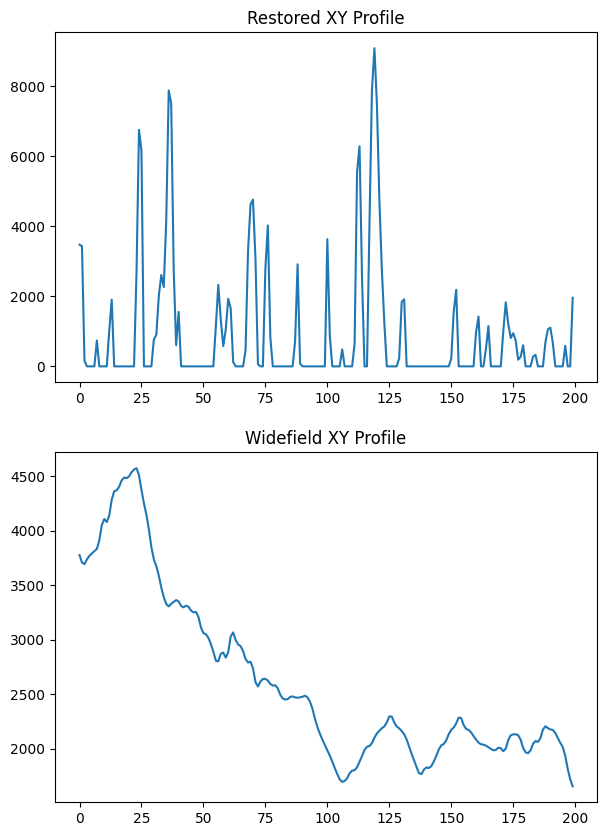

In [56]:
import matplotlib.pyplot as plt

xy_profile_restored = restored_crop[zcr,ycr,:]
xy_profile_widefield = widefield_crop[zcw,ycw,:]

fig, ax = plt.subplots(2,1, figsize=(7,10))

ax[0].plot(xy_profile_restored)
ax[0].set_title('Restored XY Profile')
ax[1].plot(xy_profile_widefield)
ax[1].set_title('Widefield XY Profile')

Text(0.5, 1.0, 'Widefield Z Profile')

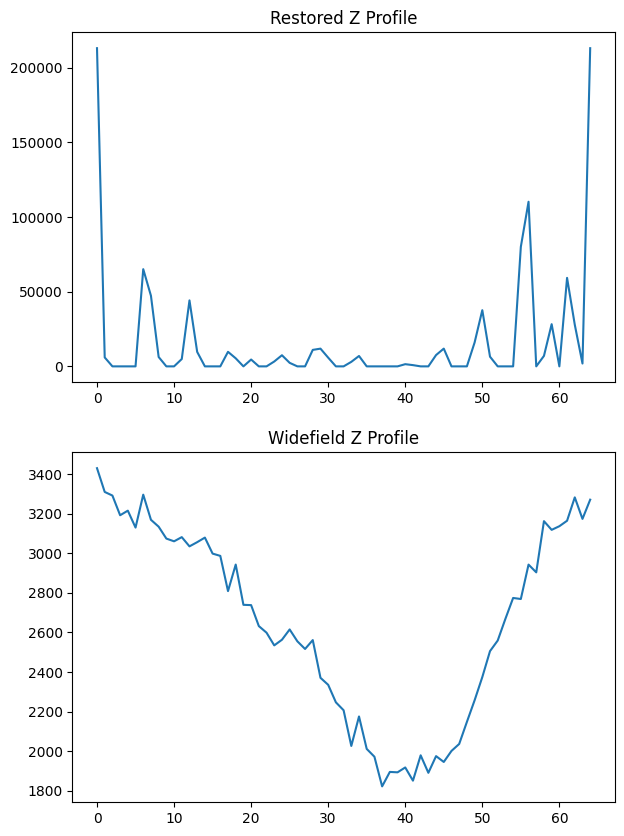

In [57]:
z_profile_restored = restored_crop[:,ycr,xcr]
z_profile_widefield = widefield_crop[:,ycw,xcw]

fig, ax = plt.subplots(2,1, figsize=(7,10))

ax[0].plot(z_profile_restored)
ax[0].set_title('Restored Z Profile')
ax[1].plot(z_profile_widefield)
ax[1].set_title('Widefield Z Profile')
